In [33]:


import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


class CollectData:
	def __init__(self):
		self.TP = []
		self.FP = []
		self.FN = []
		self.TN = []

	def reload(self,groundtruth,probgraph):
		"""
		:param groundtruth:  list,groundtruth image list
		:param probgraph:    list,prob image list
		:return:  None
		"""
		self.groundtruth = groundtruth
		self.probgraph = probgraph
		self.TP = []
		self.FP = []
		self.FN = []
		self.TN = []

	def statistics(self):
		"""
		calculate FPR TPR Precision Recall IoU
		:return: (FPR,TPR,AUC),(Precision,Recall,MAP),IoU
		"""
		for threshold in tqdm(range(0,2)):
			temp_TP=0.0
			temp_FP=0.0
			temp_FN=0.0
			temp_TN=0.0
			assert(len(self.groundtruth)==len(self.probgraph))

			for index in range(len(self.groundtruth)):
				gt_img=cv2.imread(self.groundtruth[index])[:,:,0]
				prob_img=cv2.imread(self.probgraph[index])[:,:,0]

				gt_img=(gt_img>0)*1
				prob_img=(prob_img>=threshold)*1

				temp_TP = temp_TP + (np.sum(prob_img * gt_img))
				temp_FP = temp_FP + np.sum(prob_img * ((1 - gt_img)))
				temp_FN = temp_FN + np.sum(((1 - prob_img)) * ((gt_img)))
				temp_TN = temp_TN + np.sum(((1 - prob_img)) * (1 - gt_img))

			self.TP.append(temp_TP)
			self.FP.append(temp_FP)
			self.FN.append(temp_FN)
			self.TN.append(temp_TN)

		self.TP = np.asarray(self.TP).astype('float32')
		self.FP = np.asarray(self.FP).astype('float32')
		self.FN = np.asarray(self.FN).astype('float32')
		self.TN = np.asarray(self.TN).astype('float32')

		FPR = (self.FP) / (self.FP + self.TN)
		TPR = (self.TP) / (self.TP + self.FN)
		AUC = np.round(np.sum((TPR[1:] + TPR[:-1]) * (FPR[:-1] - FPR[1:])) / 2., 4)

		Precision = (self.TP) / (self.TP + self.FP)
		Recall = self.TP / (self.TP + self.FN)
		MAP = np.round(np.sum((Precision[1:] + Precision[:-1]) * (Recall[:-1] - Recall[1:])) / 2.,4)

		iou=self.IoU()

		return (FPR,TPR,AUC),(Precision,Recall,MAP),iou

	def IoU(self,threshold=1):
		"""
		to calculate IoU
		:param threshold: numerical,a threshold for gray image to binary image
		:return:  IoU
		"""
		intersection=0.0
		union=0.0

		for index in range(len(self.groundtruth)):
			gt_img = cv2.imread(self.groundtruth[index])[:, :, 0]
			prob_img = cv2.imread(self.probgraph[index])[:, :, 0]

			gt_img = (gt_img > 0) * 1
			prob_img = (prob_img >= threshold) * 1

			intersection=intersection+np.sum(gt_img*prob_img)
			union=union+np.sum(gt_img)+np.sum(prob_img)-np.sum(gt_img*prob_img)
		iou=np.round(intersection/union,4)
		return iou

	def debug(self):
		"""
		show debug info
		:return: None
		"""
		print("Now enter debug mode....\nPlease check the info bellow:")
		print("total groundtruth: %d   total probgraph: %d\n"%(len(self.groundtruth),len(self.probgraph)))
		for index in range(len(self.groundtruth)):
			print(self.groundtruth[index],self.probgraph[index])
		print("Please confirm the groundtruth and probgraph name is opposite")


class DrawCurve:
	"""
	draw ROC/PR curve
	"""
	def __init__(self,savepath):
		self.savepath=savepath
		self.colorbar=['red','green','blue','black']
		self.linestyle=['-','-.','--',':','-*']

	def reload(self,xdata,ydata,auc,dataName,modelName):
		"""
		this function is to update data for Function roc/pr to draw
		:param xdata:  list,x-coord of roc(pr)
		:param ydata:  list,y-coord of roc(pr)
		:param auc:    numerical,area under curve
		:param dataName: string,name of dataset
		:param modelName: string,name of test model
		:return:  None
		"""
		self.xdata.append(xdata)
		self.ydata.append(ydata)
		self.modelName.append(modelName)
		self.auc.append(auc)
		self.dataName=dataName

	def newly(self,modelnum):
		"""
		renew all the data
		:param modelnum:  numerical,number of models to draw
		:return:  None
		"""
		self.modelnum = modelnum
		self.xdata = []
		self.ydata = []
		self.modelName = []
		self.auc = []

	def roc(self):
		"""
		draw ROC curve,save the curve graph to  savepath
		:return: None
		"""
		plt.figure(1)
		plt.title('ROC Curve of %s'%self.dataName, fontsize=15)
		plt.xlabel("False Positive Rate", fontsize=15)
		plt.ylabel("True Positive Rate", fontsize=15)
		plt.xlim(0.5, 1)
		plt.ylim(0.5, 1)
		plt.xticks(fontsize=12)
		plt.yticks(fontsize=12)
		for i in range(self.modelnum):
			plt.plot(self.xdata[i], self.ydata[i],  linewidth=2.0,  label=self.modelName[i]+',AUC:' + str(self.auc[i]))
		plt.legend()
		plt.savefig(self.savepath+'%s_ROC.png'%self.dataName, dpi=800)
		#plt.show()


	def pr(self):
		"""
		draw PR curve,save the curve to  savepath
		:return: None
		"""
		plt.figure(2)
		plt.title('PR Curve of %s'%self.dataName, fontsize=15)
		plt.xlabel("Recall", fontsize=15)
		plt.ylabel("Precision", fontsize=15)
		plt.xlim(0.5, 1)
		plt.ylim(0.5, 1)
		plt.xticks(fontsize=12)
		plt.yticks(fontsize=12)
		for i in range(self.modelnum):
			plt.plot(self.xdata[i], self.ydata[i],  linewidth=2.0, label=self.modelName[i]+',MAP:' + str(self.auc[i]))
		plt.legend()
		plt.savefig(self.savepath+'%s_PR.png'%self.dataName, dpi=800)
		#plt.show()


def fileList(imgpath,filetype):
	return glob.glob(imgpath+filetype)


def drawCurve(gtlist,problist,modelName,dataset,savepath='./'):
	"""
	draw ROC PR curve,calculate AUC MAP IoU
	:param gtlist:  list,groundtruth list
	:param problist: list,list of probgraph list
	:param modelName:  list,name of test,model
	:param dataset: string,name of dataset
	:param savepath: string,path to save curve
	:return:
	"""
	assert(len(problist)==len(modelName))

	process = CollectData()
	painter_roc = DrawCurve(savepath)
	painter_pr = DrawCurve(savepath)
	modelNum=len(problist)
	painter_roc.newly(modelNum)
	painter_pr.newly(modelNum)

	# calculate param
	for index in range(modelNum):
		process.reload(gtlist,problist[index])
		(FPR, TPR, AUC), (Precision, Recall, MAP),IoU = process.statistics()
		painter_roc.reload(FPR, TPR, AUC,dataset, modelName[index])
		painter_pr.reload(Precision, Recall, MAP, dataset, modelName[index])

	# draw curve and save
	painter_roc.roc()
	painter_pr.pr()



100%|██████████| 2/2 [00:00<00:00, 17.26it/s]


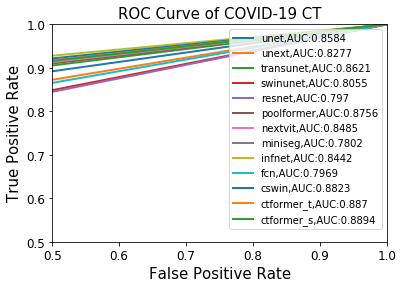

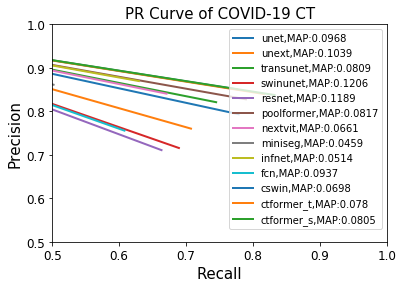

In [34]:

if __name__=="__main__":
	# gt = fileList('./datasets/COVID-19-Inf/TestingSet/LungInfection-Test/GT/', '*.png')
	gt = fileList('./outputs/Inf/gt/', '*.png')

	unet = fileList('./outputs/Inf/UNet/crossVal0/', '*.png')
	unext = fileList('./outputs/Inf/UNeXt/crossVal0/', '*.png')
	transunet = fileList('./outputs/Inf/TransUNet/crossVal0/', '*.png')
	swinunet = fileList('./outputs/Inf/SwinUNet/crossVal0/', '*.png')
	swint = fileList('./outputs/Inf/swinT/crossVal0/', '*.png')
	segnet = fileList('./outputs/Inf/SegNet/crossVal0/', '*.png')
	resnet = fileList('./outputs/Inf/resnet/crossVal0/', '*.png')
	pspnet = fileList('./outputs/Inf/PSPNet/crossVal0/', '*.png')
	poolformer = fileList('./outputs/Inf/poolformer/crossVal0/', '*.png')
	nextvit = fileList('./outputs/Inf/nextvit/crossVal0/', '*.png')
	miniseg = fileList('./outputs/Inf/MiniSeg/crossVal0/', '*.png')
	infnet = fileList('./outputs/Inf/InfNet/crossVal0/', '*.png')
	fcn = fileList('./outputs/Inf/FCN/crossVal0/', '*.png')
	deeplab = fileList('./outputs/Inf/DeepLabv3/crossVal0/', '*.png')
	cswin = fileList('./outputs/Inf/cswin/crossVal0/', '*.png')
	ctformer_t = fileList('./outputs/Inf/ctformer_t/crossVal0/', '*.png')
	ctformer_s = fileList('./outputs/Inf/ctformer_s/crossVal0/', '*.png')
	# ctformer_b = fileList('./outputs/Inf/ctformer_b/crossVal0/', '*.png')

	# modelName=['unet','unext','transunet', 'swinunet', 'swint','segnet', 'resnet', 'pspnet', 'poolformer', 'nextvit', 'miniseg', 'infnet', 'fcn', 'deeplab', 'cswin', 'ctformer_t', 'ctformer_s', 'ctformer_b']
	# modelName=['unet','unext','transunet', 'swinunet', 'swint','segnet', 'resnet', 'pspnet', 'poolformer', 'nextvit', 'miniseg', 'infnet', 'fcn', 'deeplab', 'cswin', 'ctformer_t', 'ctformer_s']
	modelName=['unet','unext','transunet', 'swinunet',  'resnet', 'poolformer', 'nextvit', 'miniseg', 'infnet', 'fcn', 'cswin', 'ctformer_t', 'ctformer_s']


	# drawCurve(gt,[unet,unext,transunet, swinunet, swint,segnet, resnet, pspnet, poolformer, nextvit, miniseg, infnet, fcn, deeplab, cswin, ctformer_t, ctformer_s, ctformer_b],modelName,'COVID-19 CT')
	# drawCurve(gt,[unet,unext,transunet, swinunet, swint,segnet, resnet, pspnet, poolformer, nextvit, miniseg, infnet, fcn, deeplab, cswin, ctformer_t, ctformer_s],modelName,'COVID-19 CT')
	drawCurve(gt,[unet,unext,transunet, swinunet, resnet, poolformer, nextvit, miniseg, infnet, fcn, cswin, ctformer_t, ctformer_s],modelName,'COVID-19 CT')


In [15]:


# MAE, Precision, Recall, F-measure, IoU, Precision-Recall curves
import numpy as np
from skimage import io

import matplotlib.pyplot as plt

def mask_normalize(mask):
# input 'mask': HxW
# output: HxW [0,255]
    return mask/(np.amax(mask)+1e-8)

def compute_mae(mask1,mask2):
# input 'mask1': HxW or HxWxn (asumme that all the n channels are the same and only the first channel will be used)
#       'mask2': HxW or HxWxn
# output: a value MAE, Mean Absolute Error
    if(len(mask1.shape)<2 or len(mask2.shape)<2):
        print("ERROR: Mask1 or mask2 is not matrix!")
        exit()
    if(len(mask1.shape)>2):
        mask1 = mask1[:,:,0]
    if(len(mask2.shape)>2):
        mask2 = mask2[:,:,0]
    if(mask1.shape!=mask2.shape):
        print("ERROR: The shapes of mask1 and mask2 are different!")
        exit()

    h,w = mask1.shape[0],mask1.shape[1]
    mask1 = mask_normalize(mask1)
    mask2 = mask_normalize(mask2)
    sumError = np.sum(np.absolute((mask1.astype(float) - mask2.astype(float))))
    maeError = sumError/(float(h)*float(w)+1e-8)

    return maeError


def compute_ave_MAE_of_methods(gt_name_list,rs_dir_lists):
#input 'gt_name_list': ground truth name list
#input 'rs_dir_lists': to-be-evaluated mask directories (not the file names, just folder names)
#output average Mean Absolute Error, 1xN, N is the number of folders
#output 'gt2rs': numpy array with shape of (num_rs_dir)

    num_gt = len(gt_name_list) # number of ground truth files
    num_rs_dir = len(rs_dir_lists) # number of method folders
    if(num_gt==0):
        print("ERROR: The ground truth directory is empty!")
        exit()

    mae = np.zeros((num_gt,num_rs_dir)) # MAE of methods
    gt2rs = np.zeros((num_gt,num_rs_dir)) # indicate if the mask mae of methods is correctly computed
    for i in range(0,num_gt):
        print('-Processed %d/%d'%(i+1,num_gt),end='\r')
        #print("Completed {:2.0%}".format(i / num_gt), end="\r") # print percentile of processed, python 3.0 and newer version
        gt = io.imread(gt_name_list[i]) # read ground truth
        gt_name = gt_name_list[i].split('/')[-1] # get the file name of the ground truth
        for j in range(0,num_rs_dir):
            tmp_mae = 0.0
            try:
                rs = io.imread(rs_dir_lists[j]+gt_name) # read the corresponding mask of each method
            except IOError:
                #print('ERROR: Couldn\'t find the following file:',rs_dir_lists[j]+gt_name)
                continue
            try:
                tmp_mae = compute_mae(gt,rs) # compute the mae
            except IOError:
                #print('ERROR: Fails in compute_mae!')
                continue
            mae[i][j] = tmp_mae
            gt2rs[i][j] = 1.0
    mae_col_sum = np.sum(mae,0) # compute the sum of MAE of each method
    gt2rs = np.sum(gt2rs,0) # compute the number of correctly computed MAE of each method
    ave_maes = mae_col_sum/(gt2rs+1e-8) # compute the average MAE of each method
    return ave_maes, gt2rs


def compute_pre_rec(gt,mask,mybins=np.arange(0,256)):

    if(len(gt.shape)<2 or len(mask.shape)<2):
        print("ERROR: gt or mask is not matrix!")
        exit()
    if(len(gt.shape)>2): # convert to one channel
        gt = gt[:,:,0]
    if(len(mask.shape)>2): # convert to one channel
        mask = mask[:,:,0]
    if(gt.shape!=mask.shape):
        print("ERROR: The shapes of gt and mask are different!")
        exit()

    gtNum = gt[gt>128].size # pixel number of ground truth foreground regions
    pp = mask[gt>128] # mask predicted pixel values in the ground truth foreground region
    nn = mask[gt<=128] # mask predicted pixel values in the ground truth bacground region

    pp_hist,pp_edges = np.histogram(pp,bins=mybins) #count pixel numbers with values in each interval [0,1),[1,2),...,[mybins[i],mybins[i+1]),...,[254,255)
    nn_hist,nn_edges = np.histogram(nn,bins=mybins)

    pp_hist_flip = np.flipud(pp_hist) # reverse the histogram to the following order: (255,254],...,(mybins[i+1],mybins[i]],...,(2,1],(1,0]
    nn_hist_flip = np.flipud(nn_hist)

    pp_hist_flip_cum = np.cumsum(pp_hist_flip) # accumulate the pixel number in intervals: (255,254],(255,253],...,(255,mybins[i]],...,(255,0]
    nn_hist_flip_cum = np.cumsum(nn_hist_flip)

    precision = pp_hist_flip_cum/(pp_hist_flip_cum + nn_hist_flip_cum+1e-8) #TP/(TP+FP)
    recall = pp_hist_flip_cum/(gtNum+1e-8) #TP/(TP+FN)

    precision[np.isnan(precision)]= 0.0
    recall[np.isnan(recall)] = 0.0

    return np.reshape(precision,(len(precision))),np.reshape(recall,(len(recall)))


def compute_PRE_REC_FM_of_methods(gt_name_list,rs_dir_lists,beta=0.3):
#input 'gt_name_list': ground truth name list
#input 'rs_dir_lists': to-be-evaluated mask directories (not the file names, just folder names)
#output precision 'PRE': numpy array with shape of (num_rs_dir, 256)
#       recall    'REC': numpy array with shape of (num_rs_dir, 256)
#       F-measure (beta) 'FM': numpy array with shape of (num_rs_dir, 256)

    mybins = np.arange(0,256) # different thresholds to achieve binarized masks for pre, rec, Fm measures

    num_gt = len(gt_name_list) # number of ground truth files
    num_rs_dir = len(rs_dir_lists) # number of method folders
    if(num_gt==0):
        #print("ERROR: The ground truth directory is empty!")
        exit()

    PRE = np.zeros((num_gt,num_rs_dir,len(mybins)-1)) # PRE: with shape of (num_gt, num_rs_dir, 256)
    REC = np.zeros((num_gt,num_rs_dir,len(mybins)-1)) # REC: the same shape with PRE
    # FM = np.zeros((num_gt,num_rs_dir,len(mybins)-1)) # Fm: the same shape with PRE
    gt2rs = np.zeros((num_gt,num_rs_dir)) # indicate if the mask of methods is correctly computed

    for i in range(0,num_gt):
        print('>>Processed %d/%d'%(i+1,num_gt),end='\r')
        gt = io.imread(gt_name_list[i]) # read ground truth
        gt = mask_normalize(gt)*255.0 # convert gt to [0,255]
        gt_name = gt_name_list[i].split('/')[-1] # get the file name of the ground truth "xxx.png"

        for j in range(0,num_rs_dir):
            pre, rec, f = np.zeros(len(mybins)), np.zeros(len(mybins)), np.zeros(len(mybins)) # pre, rec, f or one mask w.r.t different thresholds
            try:
                rs = io.imread(rs_dir_lists[j]+gt_name) # read the corresponding mask from each method
                rs = mask_normalize(rs)*255.0 # convert rs to [0,255]
            except IOError:
                #print('ERROR: Couldn\'t find the following file:',rs_dir_lists[j]+gt_name)
                continue
            try:
                pre, rec = compute_pre_rec(gt,rs,mybins=np.arange(0,256))
            except IOError:
                #print('ERROR: Fails in compute_mae!')
                continue

            PRE[i,j,:] = pre
            REC[i,j,:] = rec
            gt2rs[i,j] = 1.0
    print('\n')
    gt2rs = np.sum(gt2rs,0) # num_rs_dir
    gt2rs = np.repeat(gt2rs[:, np.newaxis], 255, axis=1) #num_rs_dirx255

    PRE = np.sum(PRE,0)/(gt2rs+1e-8) # num_rs_dirx255, average PRE over the whole dataset at every threshold
    REC = np.sum(REC,0)/(gt2rs+1e-8) # num_rs_dirx255
    FM = (1+beta)*PRE*REC/(beta*PRE+REC+1e-8) # num_rs_dirx255

    return PRE, REC, FM, gt2rs


def plot_save_pr_curves(PRE, REC, method_names, lineSylClr, linewidth, xrange=(0.0,1.0), yrange=(0.0,1.0), dataset_name = 'TEST', save_dir = './', save_fmt = 'pdf'):

    fig1 = plt.figure(1)
    num = PRE.shape[0]
    for i in range(0,num):
        if (len(np.array(PRE[i]).shape)!=0):
            plt.plot(REC[i], PRE[i],lineSylClr[i],linewidth=linewidth[i],label=method_names[i])

    plt.xlim(xrange[0],xrange[1])
    plt.ylim(yrange[0],yrange[1])

    xyrange1 = np.arange(xrange[0],xrange[1]+0.01,0.1)
    xyrange2 = np.arange(yrange[0],yrange[1]+0.01,0.1)

    plt.tick_params(direction='in')
    plt.xticks(xyrange1,fontsize=15,fontname='serif')
    plt.yticks(xyrange2,fontsize=15,fontname='serif')

    ## draw dataset name
    plt.text((xrange[0]+xrange[1])/2.0,yrange[0]+0.02,dataset_name,horizontalalignment='center',fontsize=20, fontname='serif',fontweight='bold')

    plt.xlabel('Recall',fontsize=20,fontname='serif')
    plt.ylabel('Precision',fontsize=20,fontname='serif')

    font1 = {'family': 'serif',
    'weight': 'normal',
    'size': 7,
    }

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [len(handles)-x for x in range(1,len(handles)+1)]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],loc='lower left', prop=font1)
    plt.grid(linestyle='--')
    fig1.savefig(save_dir+dataset_name+"_pr_curves."+save_fmt,bbox_inches='tight',dpi=300)
    print('>>PR-curves saved: %s'%(save_dir+dataset_name+"_pr_curves."+save_fmt))


def plot_save_fm_curves(FM, mybins, method_names, lineSylClr, linewidth, xrange=(0.0,1.0), yrange=(0.0,1.0), dataset_name = 'TEST', save_dir = './', save_fmt = 'pdf'):

    fig2 = plt.figure(2)
    num = FM.shape[0]
    for i in range(0,num):
        if (len(np.array(FM[i]).shape)!=0):
            plt.plot(np.array(mybins[0:-1]).astype(np.float)/255.0, FM[i],lineSylClr[i],linewidth=linewidth[i],label=method_names[i])

    plt.xlim(xrange[0],xrange[1])
    plt.ylim(yrange[0],yrange[1])

    xyrange1 = np.arange(xrange[0],xrange[1]+0.01,0.1)
    xyrange2 = np.arange(yrange[0],yrange[1]+0.01,0.1)

    plt.tick_params(direction='in')
    plt.xticks(xyrange1,fontsize=15,fontname='serif')
    plt.yticks(xyrange2,fontsize=15,fontname='serif')

    ## draw dataset name
    plt.text((xrange[0]+xrange[1])/2.0,yrange[0]+0.02,dataset_name,horizontalalignment='center',fontsize=20, fontname='serif',fontweight='bold')

    plt.xlabel('Thresholds',fontsize=20,fontname='serif')
    plt.ylabel('F-measure',fontsize=20,fontname='serif')

    font1 = {'family': 'serif',
    'weight': 'normal',
    'size': 7,
    }

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [len(handles)-x for x in range(1,len(handles)+1)]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],loc='lower left', prop=font1)
    plt.grid(linestyle='--')
    fig2.savefig(save_dir+dataset_name+"_fm_curves."+save_fmt,bbox_inches='tight',dpi=300)
    print('>>F-measure curves saved: %s'%(save_dir+dataset_name+"_fm_curves."+save_fmt))

------0. set the data path------


------1. Compute the average MAE of Methods------
-Processed 48/48

>>unet: num_rs/num_gt-> 48/48, aveMAE-> 0.069
>>unext: num_rs/num_gt-> 48/48, aveMAE-> 0.088
>>transunet: num_rs/num_gt-> 48/48, aveMAE-> 0.073
>>swinunet: num_rs/num_gt-> 48/48, aveMAE-> 0.097
>>resnet: num_rs/num_gt-> 48/48, aveMAE-> 0.103
>>poolformer: num_rs/num_gt-> 48/48, aveMAE-> 0.063
>>nextvit: num_rs/num_gt-> 48/48, aveMAE-> 0.091
>>miniseg: num_rs/num_gt-> 48/48, aveMAE-> 0.158
>>infnet: num_rs/num_gt-> 48/48, aveMAE-> 0.102
>>fcn: num_rs/num_gt-> 48/48, aveMAE-> 0.116
>>cswin: num_rs/num_gt-> 48/48, aveMAE-> 0.063
>>ctformer_t: num_rs/num_gt-> 48/48, aveMAE-> 0.056
>>ctformer_s: num_rs/num_gt-> 48/48, aveMAE-> 0.053


------2. Compute the Precision, Recall and F-measure of Methods------
>>Processed 48/48

>> unet : num_rs/num_gt-> 48/48, maxF->0.754,  meanF->0.752, 
>> unext : num_rs/num_gt-> 48/48, maxF->0.699,  meanF->0.697, 
>> transunet : num_rs/num_gt-> 48/48, maxF->0

IndexError: list index out of range

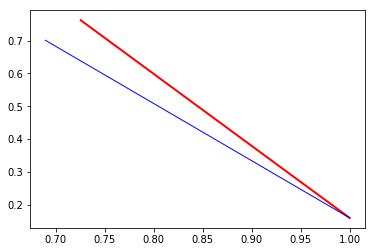

In [16]:
# demo
import numpy as np
from skimage import io
import glob


## 0. =======set the data path=======
print("------0. set the data path------")

# >>>>>>> Follows have to be manually configured <<<<<<< #
data_name = 'TEST-DATA' # this will be drawn on the bottom center of the figures
data_dir = './outputs/Inf/' # set the data directory,
                          # ground truth and results to-be-evaluated should be in this directory
                          # the figures of PR and F-measure curves will be saved in this directory as well
gt_dir = 'gt' # set the ground truth folder name
rs_dirs=['unet','unext','transunet', 'swinunet',  'resnet', 'poolformer', 'nextvit', 'miniseg', 'infnet', 'fcn', 'cswin', 'ctformer_t', 'ctformer_s']

# rs_dirs = ['rs1','rs2'] # set the folder names of different methods
                        # 'rs1' contains the result of method1
                        # 'rs2' contains the result of method 2
                        # we suggest to name the folder as the method names because they will be shown in the figures' legend
lineSylClr = ['r-','b-'] # curve style, same size with rs_dirs
linewidth = [2,1] # line width, same size with rs_dirs
# >>>>>>> Above have to be manually configured <<<<<<< #

gt_name_list = glob.glob('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/gt'+'/'+'*.png') # get the ground truth file name list

## get directory list of predicted maps
rs_dir_lists = []
# for i in range(len(rs_dirs)):
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/UNet/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/UNeXt/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/TransUNet/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/SwinUNet/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/resnet/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/poolformer/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/nextvit/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/MiniSeg/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/InfNet/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/FCN/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/cswin/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/ctformer_t/crossVal0'+'/')
rs_dir_lists.append('/root/workspace/data/ctb/COVID-19-CT/semi_ct/outputs/Inf/ctformer_s/crossVal0'+'/')

print('\n')


## 1. =======compute the average MAE of methods=========
print("------1. Compute the average MAE of Methods------")
aveMAE, gt2rs_mae = compute_ave_MAE_of_methods(gt_name_list,rs_dir_lists)
print('\n')
for i in range(0,len(rs_dirs)):
    print('>>%s: num_rs/num_gt-> %d/%d, aveMAE-> %.3f'%(rs_dirs[i], gt2rs_mae[i], len(gt_name_list), aveMAE[i]))


## 2. =======compute the Precision, Recall and F-measure of methods=========
# from measures import compute_PRE_REC_FM_of_methods,plot_save_pr_curves,plot_save_fm_curves

print('\n')
print("------2. Compute the Precision, Recall and F-measure of Methods------")
PRE, REC, FM, gt2rs_fm = compute_PRE_REC_FM_of_methods(gt_name_list,rs_dir_lists,beta=0.3)
for i in range(0,FM.shape[0]):
    print(">>", rs_dirs[i],":", "num_rs/num_gt-> %d/%d,"%(int(gt2rs_fm[i][0]),len(gt_name_list)), "maxF->%.3f, "%(np.max(FM,1)[i]), "meanF->%.3f, "%(np.mean(FM,1)[i]))
print('\n')


## 3. =======Plot and save precision-recall curves=========
print("------ 3. Plot and save precision-recall curves------")
plot_save_pr_curves(PRE, # numpy array (num_rs_dir,255), num_rs_dir curves will be drawn
                    REC, # numpy array (num_rs_dir,255)
                    method_names = rs_dirs, # method names, shape (num_rs_dir), will be included in the figure legend
                    lineSylClr = lineSylClr, # curve styles, shape (num_rs_dir)
                    linewidth = linewidth, # curve width, shape (num_rs_dir)
                    xrange = (0.5,1.0), # the showing range of x-axis
                    yrange = (0.5,1.0), # the showing range of y-axis
                    dataset_name = data_name, # dataset name will be drawn on the bottom center position
                    save_dir = data_dir, # figure save directory
                    save_fmt = 'png') # format of the to-be-saved figure
print('\n')

## 4. =======Plot and save F-measure curves=========
print("------ 4. Plot and save F-measure curves------")
plot_save_fm_curves(FM, # numpy array (num_rs_dir,255), num_rs_dir curves will be drawn
                    mybins = np.arange(0,256),
                    method_names = rs_dirs, # method names, shape (num_rs_dir), will be included in the figure legend
                    lineSylClr = lineSylClr, # curve styles, shape (num_rs_dir)
                    linewidth = linewidth, # curve width, shape (num_rs_dir)
                    xrange = (0.0,1.0), # the showing range of x-axis
                    yrange = (0.0,1.0), # the showing range of y-axis
                    dataset_name = data_name, # dataset name will be drawn on the bottom center position
                    save_dir = data_dir, # figure save directory
                    save_fmt = 'png') # format of the to-be-saved figure
print('\n')

print('Done!!!')



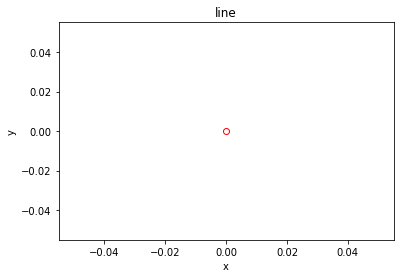

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(0,0.2,1)
y1=np.sin(x)
# plt.plot(x,y1)
plt.plot(x,y1,marker='o',mec='r',mfc='w')


plt.title('line')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


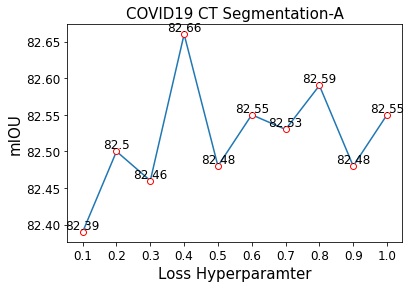

In [28]:
# coding=utf-8
import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6), dpi=100)
game = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
scores = [82.39, 82.50, 82.46, 82.66, 82.48, 82.55, 82.53, 82.59, 82.48, 82.55]
plt.plot(game, scores,marker='o',mec='r',mfc='w')
# 设置数字标签
for a, b in zip(game, scores):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=12)

plt.title('COVID19 CT Segmentation-A',fontsize=15)
plt.xlabel('Loss paramter',fontsize=15)
plt.ylabel('mIOU',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
